Wybieramy temat. Może być to temat z pierwszego projektu. Jeśli pozostajemy przy tym 
samym temacie musimy znaleźć zmienną celu. 
2. Dokonujemy eksploracji zbioru. Uzupełniamy braki danych. Dokonujemy wstępnej selekcji 
zmiennych.   
3. Dzielimy zbiór danych na treningowy testowy i w miarę możliwości na walidacyjny. 
4. Tworzymy minimum 3 modele predykcyjne (może być ich więcej) wraz z dostrojeniem 
hiperparametrów. 
5. Porównać i wybrać najlepszy model. 
6. Dokonać ostatecznej oceny wybranego modelu na zbiorze walidacyjnym. 
7. Wskazać uzysk dla firmy / odbiorcy (np. ile pieniędzy z tego będzie miała, jak wdrożenie 
wpłynie na rozpoznawalność przypadków, dla których firma wykona działania prewencyjne 
itd.) 
8. Stworzenie aplikacji wykorzystującej model 
9. Na prezentacji powinna znaleźć się krótka analiza zmiennych, omówienie wyników 
wszystkich zastosowanych technik modelowania i ich porównanie, wybór modelu i przede 
wszystkim wartość dodana jaką niesie za sobą wdrożenie

4. Odejdzie  czy nie odejdzie?  – prognozowanie zjawiska churn wśród Klientów telecom  
• Prognozowanie czy jest zagrożenie, że Klient zrezygnuje z usług firmy 
• Aplikacja dla pracowników informująca o zagrożeniu odejścia Klienta 
• https://www.kaggle.com/blastchar/telco-customer-churn 
 


In [1]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,3) 
from sklearn.feature_selection import SelectKBest,mutual_info_classif, RFE
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV,validation_curve,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import chi2
from imblearn.over_sampling import SMOTE


<H5> Assumptions & Questions: <H5>
* Some features seem ordinal (contract, multiplelines) encoding was done with labelencoder style not ordifier <br/>
* Predicted class is inbalanced 5900 no churn (0) and 1900 churn (1) (churn no churn 1:4 proportions) that is why when using gridsearch we use class_weight<br/>
* TotalCharges has quite some outliers do we deal with them via standardscaler,mixmaxscaler<br/>
* Some features are strongly interwined (i.e. has internet vs online backup, streaming etc.)<br/>
* Models with no hyperparameters are more or less same on all set and set only of correlated features with target (was lookign at positive class precision & recall)
* SelectKBest currently takes all features (so does nothing, need to tweak it)

In [2]:
#Import data 
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#During training attempt it turned out TotalCharges has empty strings and cannot be converted to number, let's remove it. 
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.dropna(inplace=True)

In [44]:
# Basic data analysis (shape, info, describe,value_counts)
#   Set has 7000k rows and 21 columns, All features are object type except:
#   SeniorCitizen, Tenure, Montlhly Charges, Total Charges. 
#   SeniorCitizen is categorical despite numerical format (i.e. takes only 1 or 0 value)
#   SeniorCitizen, MultipleLines,Contract - seem to be categorical ordinal so we will use proper encoder for them

display(df.info())
display(df.describe())
for col in df.columns:
    print(df[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


None

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


7590-VHVEG    1
0265-PSUAE    1
2956-GGUCQ    1
6008-NAIXK    1
5956-YHHRX    1
             ..
7874-ECPQJ    1
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
3186-AJIEK    1
Name: customerID, Length: 7032, dtype: int64
Male      3549
Female    3483
Name: gender, dtype: int64
0    5890
1    1142
Name: SeniorCitizen, dtype: int64
No     3639
Yes    3393
Name: Partner, dtype: int64
No     4933
Yes    2099
Name: Dependents, dtype: int64
1     613
72    362
2     238
3     200
4     176
71    170
5     133
7     131
8     123
70    119
9     119
12    117
10    116
6     110
13    109
68    100
11     99
15     99
67     98
18     97
69     95
24     94
22     90
66     89
35     88
17     87
23     85
16     80
64     80
56     80
52     80
26     79
25     79
61     76
14     76
65     76
60     76
46     74
19     73
29     72
27     72
30     72
63     72
20     71
53     70
62     70
41     70
32     69
50     68
47     68
51     68
54     68
58     67
49     66
57     65
31     65
3

In [3]:
#Customer ID carries no value in information let's drop it
df.drop('customerID',axis=1,inplace=True)

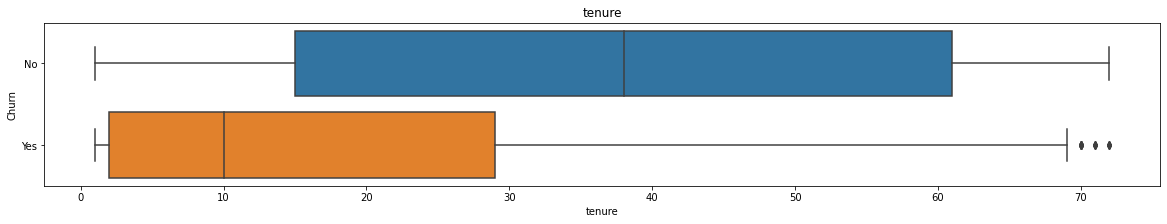

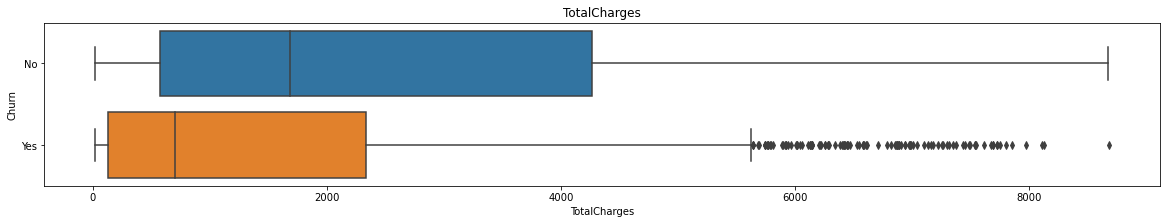

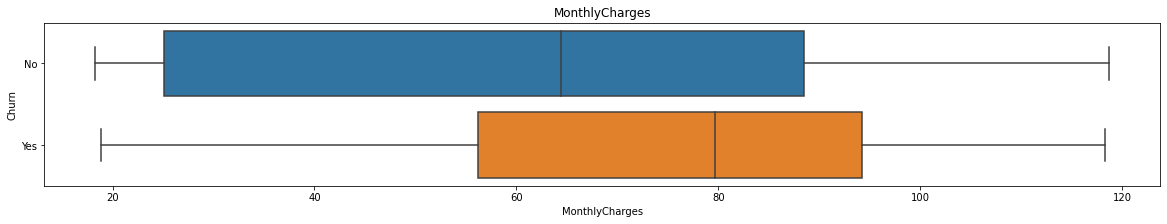

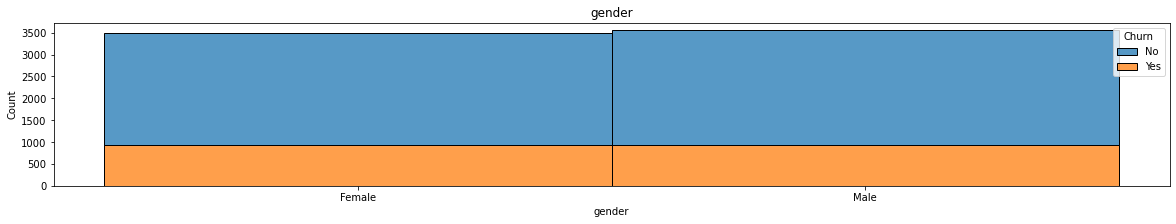

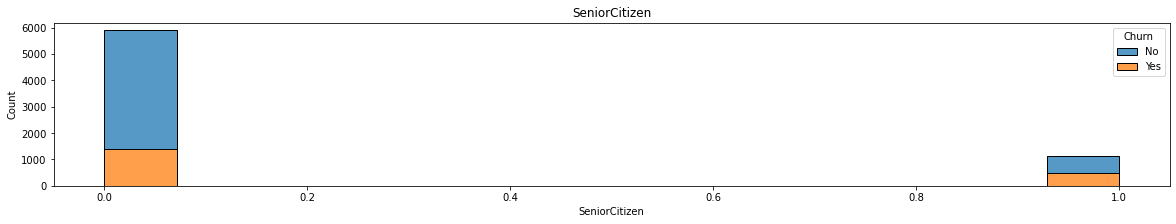

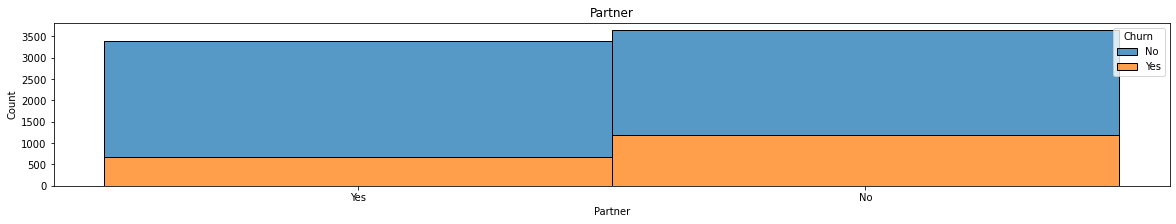

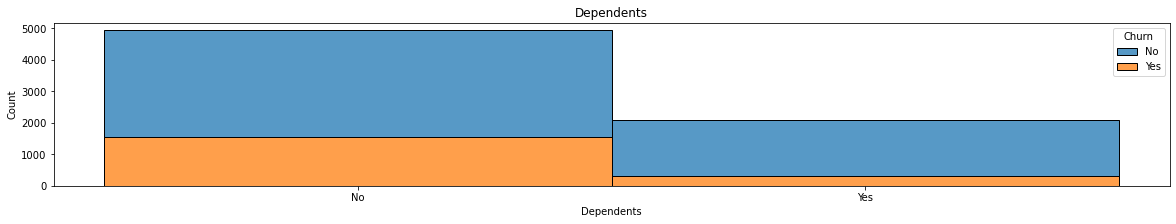

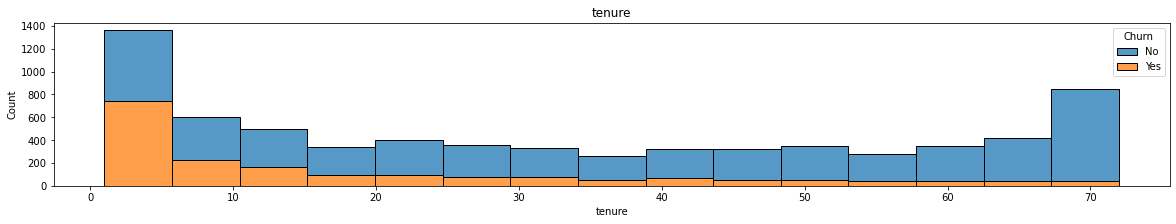

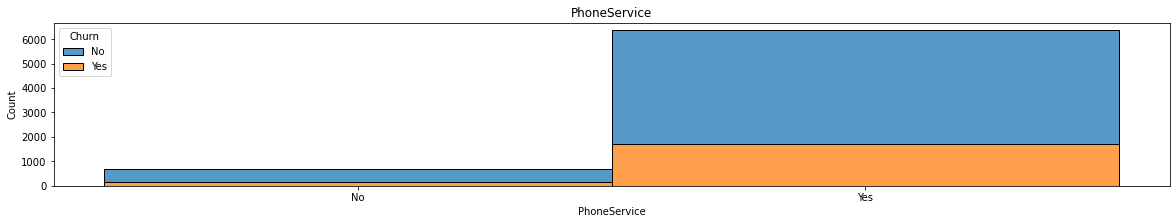

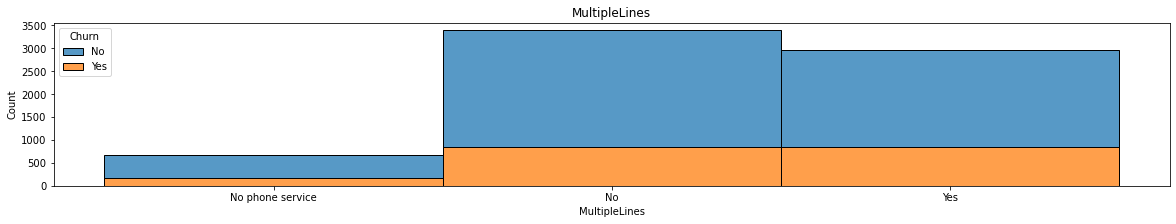

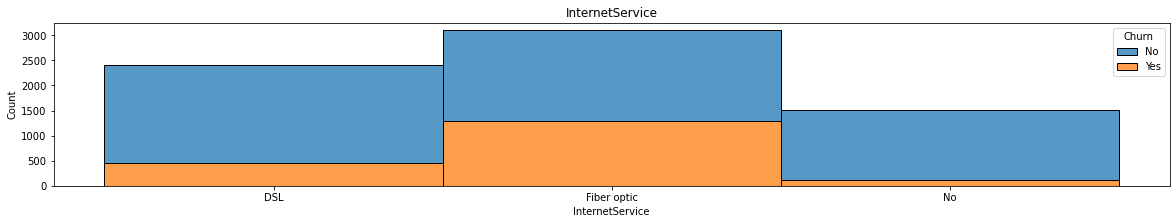

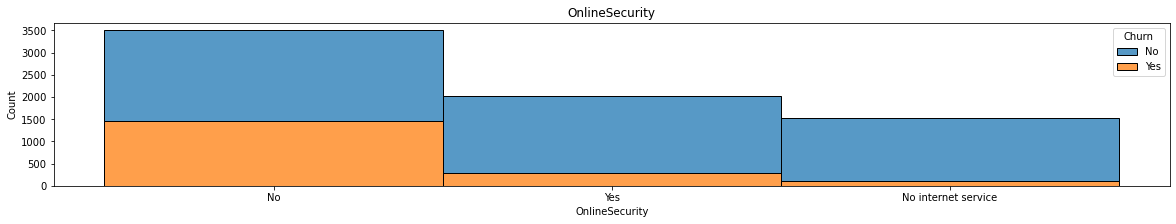

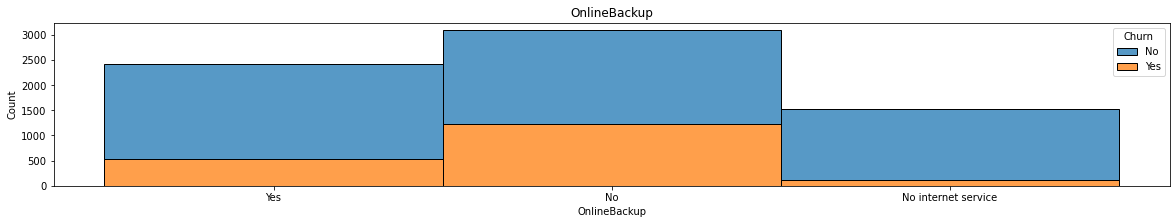

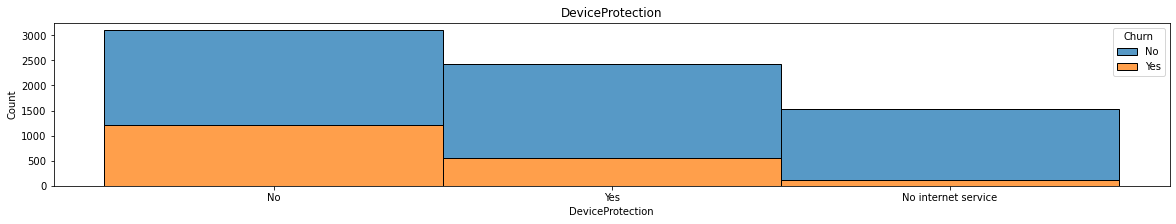

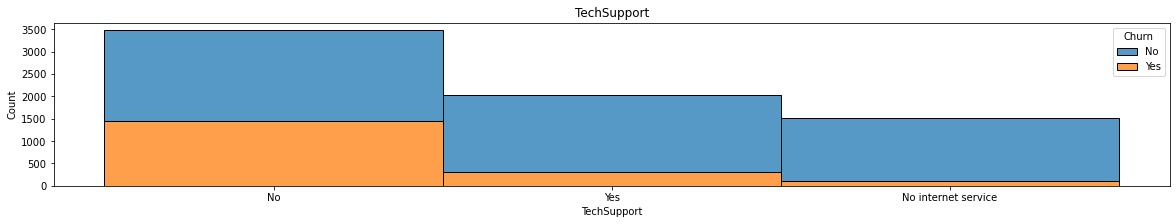

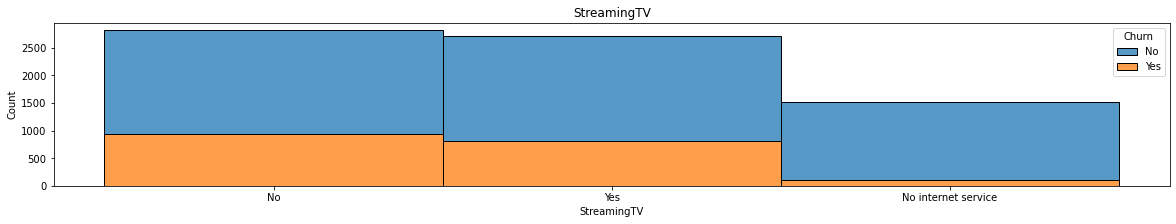

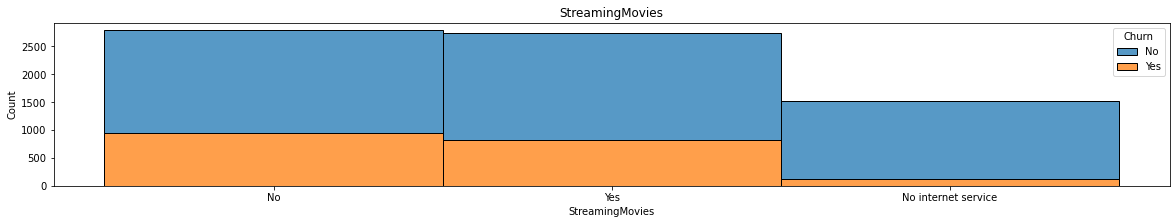

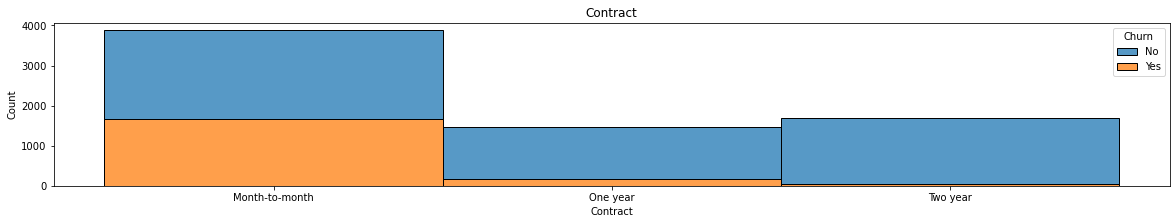

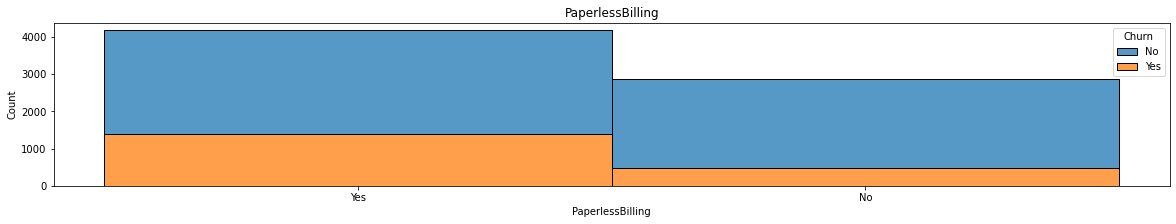

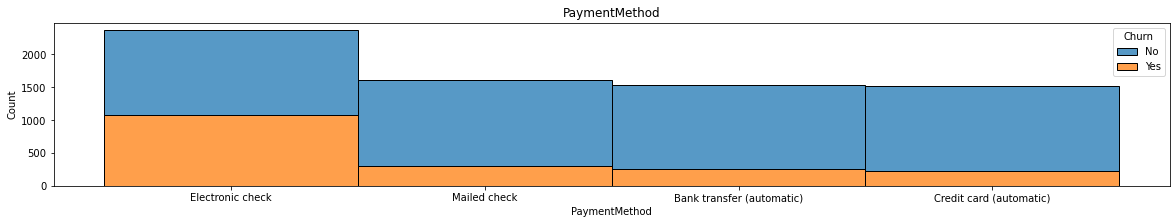

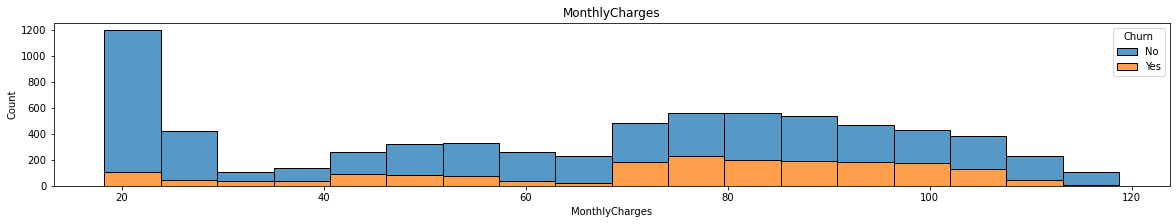

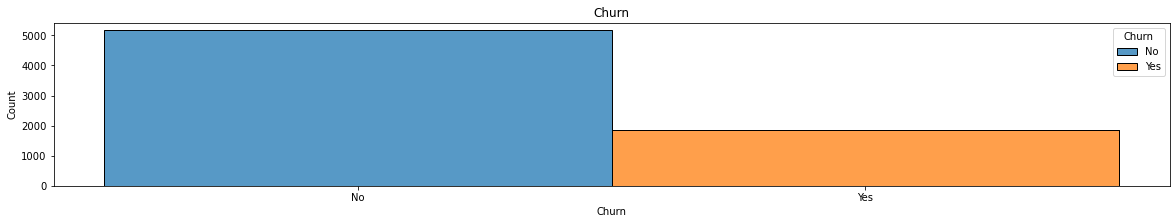

In [15]:
#split featuers into categorical & numerical to draw histograms for categorical & boxplot for numerical
numerical_features=['tenure', 'TotalCharges','MonthlyCharges']

categorical_features=[ 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'Churn']

#draw histogram for categorical & boxplot for numerical
#   Tenure, Monthly and Total Charges have corelation with Churn i.e. those hwo left last motnh had less tenure and higher monthly & total charges then those who stayed
#   Who left more often (jduging by charts):
#   Senior clients 
#   Without partner
#   With internet service 
#   Without onlince security
#   without DeviceProction
#   without tech support
#   with & without streamingTV compared to no internet service
#   with & without streamingMovies compared to no internet service
#   with Paperless billing
#   those with PaymentMethod ElectronicCheck
#   correclatin with monthlycharges

for col in numerical_features:
    sns.boxplot(data=df,x=col,y='Churn',dodge=True)
    plt.title(col)
    plt.show()

for col in categorical_features:
    sns.histplot(data=df,x=col, hue='Churn',multiple='stack')
    plt.title(col)
    plt.show()



#Some featuers seem to have stron correlation with Churn judging by charts i.e
# SeniorCitizen 1, Partner No, InternetService, DeviceProtection, Payment Methods


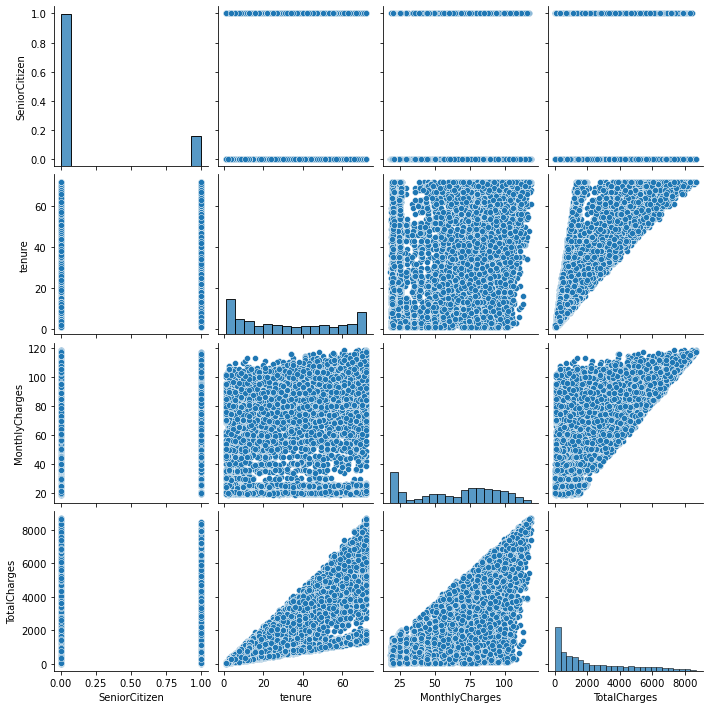

In [16]:
#Draw pairwise features to see correlation - totalcharges correlate with tenure & monthly charges because is cumulative pay over time.
#The longer tenure the more totcharges, the higher monthly the higher total
sns.pairplot(data=df)

In [4]:
#dummify categorical features & encode ordinal features & encode label class

def enc_dumm(df1: pd.DataFrame):
       #dummify categorical features
       df1=df1.copy()
       features_dummify=['gender', 'Partner', 'Dependents','PhoneService', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod']
       df1=pd.get_dummies(data=df,columns=features_dummify,drop_first=True)

       #encode ordinal features 'MultipleLines','Contract

       # Define a dictionary for encoding variable
       enc_dict = {'No phone service':0,
                   'No':1,
                   'Yes':2}
       # Create the mapped values in a new column
       df1['MultipleLines'] = df['MultipleLines'].map(enc_dict)

       # Define a dictionary for encoding variable
       enc_dict = {'Month-to-month':0,
              'One year':1,
              'Two year':2}
       # Create the mapped values in a new column
       df1['Contract'] = df['Contract'].map(enc_dict)

       le=LabelEncoder()
       df1['Churn_enc']=le.fit_transform(df1['Churn'])
       df1.drop('Churn',axis=1,inplace=True)
       return df1

In [6]:
#do ordinal encoding on categorical features & do label encoding

def enc_ord(df1: pd.DataFrame):
       #dummify categorical features
       df1=df1.copy()
       features_to_encode=['gender', 'Partner', 'Dependents','PhoneService', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'PaymentMethod']

       enc = OrdinalEncoder()
       df_1=enc.fit_transform(df[features_to_encode])
       df1[features_to_encode]=df_1

       #encode ordinal features 'MultipleLines','Contract

       # Define a dictionary for encoding variable
       enc_dict = {'No phone service':0,
              'No':1,
              'Yes':2}
       # Create the mapped values in a new column
       df1['MultipleLines'] = df['MultipleLines'].map(enc_dict)

       # Define a dictionary for encoding variable
       enc_dict = {'Month-to-month':0,
            'One year':1,
            'Two year':2}
       # Create the mapped values in a new column
       df1['Contract'] = df['Contract'].map(enc_dict)

       le=LabelEncoder()
       df1['Churn_enc']=le.fit_transform(df1['Churn'])
       df1.drop('Churn',axis=1,inplace=True)
       return df1

In [50]:
# Let's do correlation check on dummified X 
# Monthly charges, TotalCharges has strong correlation with extra features (which makes sense you pay more for extra features)
# Some features have corr=1 i.e. if someone doesn't have internet than has no streaming, online protection which makes sense
df2=enc_dumm(df)
corr=df2.corr(method='pearson')
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\User\AppData\Local\Temp/ipykernel_10752/1948597572.py:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


,SeniorCitizen,tenure,MultipleLines,Contract,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_enc
SeniorCitizen,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
tenure,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
MultipleLines,0.11,0.26,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Contract,-0.14,0.68,0.08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
MonthlyCharges,0.22,0.25,0.49,-0.07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TotalCharges,0.10,0.83,0.41,0.45,0.65,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
gender_Male,-0.00,0.01,-0.01,0.00,-0.01,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Partner_Yes,0.02,0.38,0.12,0.29,0.10,0.32,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Dependents_Yes,-0.21,0.16,-0.02,0.24,-0.11,0.06,0.01,0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PhoneService_Yes,0.01,0.01,0.67,0.00,0.25,0.11,-0.01,0.02,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [53]:
#Lets see what are the top 10 feature in terms of correlation wiht label class (churn). 
# Contract, Tenure, InternetService_Fiber optic, PaymentMethod_Electronic Check seem to have strongest correlation with label class
df2=enc_dumm(df)
corr=df2.corr()
display(corr['Churn_enc'].sort_values(ascending=False).head(5))
display(corr['Churn_enc'].sort_values(ascending=False).tail(5))

Churn_enc                         1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
PaperlessBilling_Yes              0.191454
Name: Churn_enc, dtype: float64

TechSupport_No internet service        -0.227578
DeviceProtection_No internet service   -0.227578
OnlineBackup_No internet service       -0.227578
tenure                                 -0.354049
Contract                               -0.396150
Name: Churn_enc, dtype: float64

In [57]:
# Let's try to drop fetures which have correlatino of one and use different corr method (i.e. rank spearman)
# correlation seem similar as to first method
s_corr=df2.drop(['OnlineBackup_No internet service','DeviceProtection_No internet service','TechSupport_No internet service', 'StreamingTV_No internet service', 
'StreamingMovies_No internet service','OnlineSecurity_No internet service'],axis=1).corr(method='spearman')
mask = np.zeros_like(s_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
s_corr[mask] = np.nan
(s_corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\User\AppData\Local\Temp/ipykernel_10752/1103280996.py:7: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (s_corr


,SeniorCitizen,tenure,MultipleLines,Contract,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_enc
SeniorCitizen,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
tenure,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
MultipleLines,0.13,0.29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Contract,-0.14,0.67,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
MonthlyCharges,0.22,0.28,0.53,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TotalCharges,0.11,0.89,0.43,0.47,0.64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
gender_Male,-0.00,0.00,-0.01,0.00,-0.01,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Partner_Yes,0.02,0.39,0.13,0.30,0.11,0.34,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Dependents_Yes,-0.21,0.17,-0.02,0.24,-0.11,0.08,0.01,0.45,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PhoneService_Yes,0.01,0.01,0.57,0.00,0.24,0.08,-0.01,0.02,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [61]:
#Top 10 correlations (positive & negative) after removing features with 1 correlation to Internet_Service NO
s_corr=df2.drop(['OnlineBackup_No internet service','DeviceProtection_No internet service','TechSupport_No internet service', 'StreamingTV_No internet service', 
'StreamingMovies_No internet service','OnlineSecurity_No internet service'],axis=1).corr(method='spearman')
display(s_corr['Churn_enc'].sort_values(ascending=False).head(5))
display(s_corr['Churn_enc'].sort_values(ascending=False).tail(5))#

Churn_enc                         1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
PaperlessBilling_Yes              0.191454
MonthlyCharges                    0.184167
Name: Churn_enc, dtype: float64

OnlineSecurity_Yes   -0.171270
InternetService_No   -0.227578
TotalCharges         -0.232190
tenure               -0.369659
Contract             -0.405742
Name: Churn_enc, dtype: float64

In [7]:
def splitter(X,y):
    """Takes X,y arrays and returns X_train (0.6), X_val (0.2), X_test (0.2) and y_train, y_val & y_test. 
    Does it wih randomstate 44 and stratify=y on first split. For some reason it throws error on second split. 
    Stratify option is set to yes in order to have y values (0,1) in same proportions across the 3 sets (train, test, val)"""
    X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=44,train_size=0.6,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, random_state=2021,train_size=0.5)
    return X_train,X_val,X_test, y_train, y_val, y_test

In [8]:
#Normalize and standardize features functions


def std_scaler(X_train,X_val,X_test):
    """Takes X_train,X_val and X_test and fits standard scaler on X_train, transforms X_val & X_test. 
    Returns  X_train,X_val and X_test scaled"""
    sc=StandardScaler()
    X_train=pd.DataFrame(data=sc.fit_transform(X_train),columns=X_train.columns)
    X_val=pd.DataFrame(data=sc.transform(X_val),columns=X_val.columns)
    X_test=pd.DataFrame(data=sc.transform(X_test),columns=X_test.columns)
    return X_train, X_val, X_test

def min_max_scaler(X_train, X_val,X_test):
    """Takes X_train,X_val and X_test and fits MinMaxScaler on X_train, transforms X_val & X_test. 
    Returns  X_train,X_val and X_test scaled"""
    sc=MinMaxScaler()
    X_train=pd.DataFrame(data=sc.fit_transform(X_train),columns=X_train.columns)
    X_val=pd.DataFrame(data=sc.transform(X_val),columns=X_val.columns)
    X_test=pd.DataFrame(data=sc.transform(X_test),columns=X_test.columns)
    return X_train, X_val, X_test

In [9]:
# X_train,val,test reduced by SelectKBest with mutual_info_classif
def select_features(X_train, y_train, X_val, X_test):
	"""Takes X_train, y_train, X_val and X_test. 
	Then uses SelectKBest on X_train to find features that correlate best with label class.
	score func used is called mutual_info_classif which looks at combinations of features not one by one. 
	Then apply's those features on X_val and X_test"""
	fs = SelectKBest(score_func=mutual_info_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_val_fs = fs.transform(X_val)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_val_fs, X_test_fs

#Code below can be uncommented to see bar plot of features scores
# X_dumm = enc_dumm(df)
# X_dumm_train,X_dumm_val,X_dumm_test,y_dumm_train,y_dumm_val,y_dumm_test = splitter(X_dumm.drop('Churn_enc',axis=1),X_dumm['Churn_enc'])

# fs = SelectKBest(score_func=mutual_info_classif, k='all')
# fs.fit(X_dumm_train, y_dumm_train)

# features_score_after_SelectKBest=pd.DataFrame(data=fs.scores_,index=X_dumm_train.columns,columns=['Score']).sort_values('Score',ascending=False).plot(kind='bar')

In [ ]:
#X_train,val,test reduced with RFE its tailored to a model - not used needs tweaking
# model = LogisticRegression(solver='lbfgs',max_iter=300)
# rfe = RFE(model, n_features_to_select=5)
# fit = rfe.fit(X_train, y_train)
# print("Num Features: %d" % fit.n_features_)
# print("Selected Features: %s" % fit.support_)
# # print("Feature Ranking: %s" % fit.ranking)

# X_train_rfe=X_train[X.columns[fit.support_]]
# X_val_rfe=X_val[X.columns[fit.support_]]
# X_tes_rfet=X_test[X.columns[fit.support_]]

In [10]:
#We will now define various X version to see their score with various models to establish base X and base model for hyperparamter tuning 

#X dummified with 3 features encoded as ordinal (contract, multplines, seniorcitizen)
X_dumm = enc_dumm(df)
X_dumm_train,X_dumm_val,X_dumm_test,y_dumm_train,y_dumm_val,y_dumm_test = splitter(X_dumm.drop('Churn_enc',axis=1),X_dumm['Churn_enc'])

# X dummified and standardized, scaled or both (std only, min max only,  both std & min max)
X_dumm_train_std,X_dumm_val_std,X_dumm_test_std = std_scaler(X_dumm_train,X_dumm_val,X_dumm_test)
X_dumm_train_minmax,X_dumm_val_minmax,X_dumm_test_minmax = min_max_scaler(X_dumm_train,X_dumm_val,X_dumm_test)
X_dumm_train_std_minmax,X_dumm_val_std_minmax,X_dumm_test_std_minmax = min_max_scaler(X_dumm_train_std,X_dumm_val_std,X_dumm_test_std)

#X encoded ordinally
X_ord= enc_ord(df)
X_ord_train,X_ord_val,X_ord_test,y_ord_train,y_ord_val,y_ord_test = splitter(X_ord.drop('Churn_enc',axis=1),X_ord['Churn_enc'])

# X ordinal standardized, scalerd or both (std only, min max only,  both std & min max)
X_ord_train_std,X_ord_val_std,X_ord_test_std = std_scaler(X_ord_train,X_ord_val,X_ord_test)
X_ord_train_minmax,X_ord_val_minmax,X_ord_test_minmax = min_max_scaler(X_ord_train,X_ord_val,X_ord_test)
X_ord_train_std_minmax,X_ord_val_std_minmax,X_ord_test_std_minmax = min_max_scaler(X_ord_train_std,X_ord_val_std,X_ord_test_std)

#X with features that have corr=1 removed 
feat_corr1=['OnlineBackup_No internet service','DeviceProtection_No internet service','TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service','OnlineSecurity_No internet service']
#X dummified without corr=1 
X_dumm_corr1 = enc_dumm(df).drop(feat_corr1,axis=1)
X_dumm_corr1_train,X_dumm_corr1_val,X_dumm_corr1_test,y_dumm_train,y_dumm_val,y_dumm_test = splitter(X_dumm_corr1.drop('Churn_enc',axis=1),X_dumm_corr1['Churn_enc'])

# X dummified without corr=1 standardized or scaled, or both (std only, min max only,  both std & min max)
X_dumm_corr1_train_std,X_dumm_corr1_val_std,X_dumm_corr1_test_std = std_scaler(X_dumm_corr1_train,X_dumm_corr1_val,X_dumm_corr1_test)
X_dumm_corr1_train_minmax,X_dumm_corr1_val_minmax,X_dumm_corr1_test_minmax = min_max_scaler(X_dumm_corr1_train,X_dumm_corr1_val,X_dumm_corr1_test)
X_dumm_train_std_minmax,X_dumm_val_std_minmax,X_dumm_test_std_minmax = min_max_scaler(X_dumm_corr1_train_std,X_dumm_corr1_val_std,X_dumm_corr1_test_std)

# X dummified and then features selected via KSelectBest (k=all) - this needs tweaking becuase it does nothing?
X_train_fs, X_val_fs, X_test_fs = select_features(X_dumm_train, y_dumm_train, X_dumm_val, X_dumm_test)

# X dummified and then PCA used on it
pca=PCA()
pca.fit(X_dumm_train)
X_dumm_train_pca, X_dumm_val_pca, X_dumm_test_pca = pca.transform(X_dumm_train),pca.transform(X_dumm_val),pca.transform(X_dumm_test)

# X, y oversampled to see if thise will work better for training - not used yet
# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)

#Define list of experiments (title & various X versions) for use in function that will fit, evaluate models
exp=[
    ['Dumm X',X_dumm_train,X_dumm_val,y_dumm_train,y_dumm_val],
    ['Dumm X std',X_dumm_train_std,X_dumm_val_std,y_dumm_train,y_dumm_val],
    ['Dumm X minmax',X_dumm_train_minmax,X_dumm_val_minmax,y_dumm_train,y_dumm_val],
    ['Dumm X std & minmax',X_dumm_train_std_minmax,X_dumm_val_std_minmax,y_dumm_train,y_dumm_val],
    ['Ord X',X_ord_train,X_ord_val,y_ord_train,y_ord_val],
    ['Ord X std',X_ord_train_std,X_ord_val_std,y_ord_train,y_ord_val],
    ['Ord X minmax',X_ord_train_minmax,X_ord_val_minmax,y_ord_train,y_ord_val],
    ['Ord X std&minmax',X_ord_train_std_minmax,X_ord_val_std_minmax,y_ord_train,y_ord_val],
    ['Dumm X without corr1',X_dumm_corr1_train,X_dumm_corr1_val,y_dumm_train,y_dumm_val],
    ['Dumm X without corr 1 std',X_dumm_corr1_train_std,X_dumm_corr1_val_std,y_dumm_train,y_dumm_val],
    ['Dumm X without corr 1 minmax',X_dumm_corr1_train_minmax,X_dumm_corr1_val_minmax,y_dumm_train,y_dumm_val],
    ['Dumm X without corr 1 std & minmax',X_dumm_train_std_minmax,X_dumm_val_std_minmax,y_dumm_train,y_dumm_val],
    ['Dumm X with select K best all',X_train_fs, X_val_fs,y_dumm_train,y_dumm_val],
    ['Dumm X with PCA',X_dumm_train_pca, X_dumm_val_pca,y_dumm_train,y_dumm_val],
    ]


In [11]:
def spot_check_algorithms(algorithm: list, X_y:list, mod_list: list, listparams_grid=None):
    """ Takes list of algorithms (models), list of experiments (name, X values) and list of algorithm names (models names).
        For each model & X values fits a model and evaluates it.
        returns a data frame with experiment name, model name and various metrics. 
        In our classification F1_CV (F1 cross valited 5 times) seems to be best to establish base model and base X.
    """
    
    precision_=[]
    recall_=[]
    accuracy_=[]
    f1_=[]
    f1_train_=[]
    precision_0=[]
    recall_0=[]
    class_report_=[]
    f1_cv_=[]
    f1_cv_std_=[]
    exp_=[]
    alg_=[]
    rec_cv_=[]
    prec_cv_=[]
    for el in X_y:
        exp, X_train, X_val, y_train, y_val = el
        for i,enc in enumerate(algorithm):
            enc.fit(X_train, y_train)
            pred_train=enc.predict(X_train)
            pred_val=enc.predict(X_val)
            scores_rec = cross_validate(enc,X_val,y_val,cv=5,n_jobs=-1,scoring='recall')
            rec_cv_.append(scores_rec['test_score'].mean())
            scores_prec = cross_validate(enc,X_val,y_val,cv=5,n_jobs=-1,scoring='precision')
            prec_cv_.append(scores_prec['test_score'].mean())
            precision_.append(precision_score(y_val,pred_val))
            recall_.append(recall_score(y_val,pred_val))
            accuracy_.append(accuracy_score(y_val,pred_val))
            f1_.append(f1_score(y_val,pred_val))
            precision_0.append(precision_score(y_val,pred_val,pos_label=0,average='binary'))
            recall_0.append(recall_score(y_val,pred_val,pos_label=0,average='binary'))
            class_report_.append(('enc',classification_report(y_val,pred_val)))
            f1_train_.append(f1_score(y_train,pred_train))
            scores = cross_validate(enc,X_val,y_val,cv=5,n_jobs=-1,scoring='f1')
            f1_cv_.append(scores['test_score'].mean())
            f1_cv_std_.append(scores['test_score'].std())
            exp_.append(exp)
            alg_.append(mod_list[i])
    return pd.DataFrame([exp_, alg_,precision_,prec_cv_,recall_,rec_cv_,precision_0,recall_0,accuracy_,f1_train_,f1_,f1_cv_,f1_cv_std_],
    index=['exp','model','precision_','prec_cv','recall_','rec_cv','precision_0','recall_0','accuracy','F1_train','F1','F1_CV','F1_CV_STD']).transpose()   

In [205]:
#Define list of models to spotchekc and their names in two separate lists
models_to_spotcheck=[LogisticRegression(max_iter=300,class_weight='balanced'),GaussianNB(),SGDClassifier(class_weight='balanced'),
KNeighborsClassifier(n_neighbors=5),DecisionTreeClassifier(class_weight='balanced',min_samples_leaf=5),RandomForestClassifier(class_weight='balanced',min_samples_leaf=5),
SVC()]
mod_list=['log_reg', 'naive_bayes', 'sdgc','kneighbor','dec_tree','random_forr','SVC']

#Do a spotcheck of algorithms (note for some models with recall =1 the precision can not be calculate due to 0 division therefore the warnings)
results=spot_check_algorithms(models_to_spotcheck,exp,mod_list)

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:12

In [206]:
#view results sorted by model & then F1_CV
pd.set_option("display.max_rows", 100)
results[['model','exp','precision_','recall_','prec_cv','rec_cv','F1','F1_CV']].sort_values(['model','F1_CV'],ascending=False)

#alternative way of looking at the results by specifiing experiment
# results.query("exp=='Dumm X with PCA'").sort_values('F1_CV',ascending=False).head(10)


,model,exp,precision_,recall_,prec_cv,rec_cv,F1,F1_CV
72,sdgc,Dumm X without corr 1 minmax,0.489933,0.811111,0.467907,0.741667,0.610879,0.589758
44,sdgc,Ord X minmax,0.51938,0.744444,0.473776,0.725,0.611872,0.58105
65,sdgc,Dumm X without corr 1 std,0.438988,0.819444,0.414999,0.722222,0.571705,0.567973
23,sdgc,Dumm X std & minmax,0.477977,0.813889,0.511506,0.744444,0.602261,0.55002
9,sdgc,Dumm X std,0.483761,0.786111,0.452573,0.666667,0.598942,0.547837
51,sdgc,Ord X std&minmax,0.561086,0.688889,0.50959,0.691667,0.618454,0.544739
16,sdgc,Dumm X minmax,0.57037,0.641667,0.453223,0.591667,0.603922,0.540148
79,sdgc,Dumm X without corr 1 std & minmax,0.456753,0.836111,0.502701,0.691667,0.590775,0.525783
37,sdgc,Ord X std,0.401681,0.663889,0.447556,0.747222,0.500524,0.497012
2,sdgc,Dumm X,0.578755,0.438889,0.427451,0.663889,0.49921,0.49379


<H1>Lets see results for different models<H1>

In [12]:
#function that print test & val metrics (hardcoded need to change to better coding)
def return_metrics():
    """ This function produces various metrics for train & val sets of X & y. 
    Likely will not be needed because of newer functions but keeping"""
    train_res=confusion_matrix(y_train,pred_train)
    val_res=confusion_matrix(y_val,pred_val)
    TP=[train_res[0,0],val_res[0,0]]
    FP=[train_res[0,1],val_res[0,1]]
    FN=[train_res[1,0],val_res[1,0]]
    TN=[train_res[1,1],val_res[1,1]]
    accuracy_=[accuracy_score(y_train,pred_train),accuracy_score(y_val,pred_val)]
    precision_=[precision_score(y_train,pred_train),precision_score(y_val,pred_val)]
    recall_=[recall_score(y_train,pred_train),recall_score(y_val,pred_val)]
    f1_=[f1_score(y_train,pred_train),f1_score(y_val,pred_val)]
    roc_auc_=[roc_auc_score(y_train,pred_train),roc_auc_score(y_val,pred_val)]
    res=pd.DataFrame([TP,FP,FN,TN,roc_auc_,accuracy_,precision_,recall_,f1_],index=['TP','FP','FN','TN','AUC','Accuracy','Precision','Recall','F1'],columns=['Train','Val'])
    # res=res.pivot(data=res,columns=res.index,index=res.columns)
    return res.transpose()

In [13]:
# This section is legacy i.e. have done same above in a loop but keeping, maybe needed.

#Let's define X and y - we will use dummified encoding version
X_train=X_dumm_train
y_train=y_dumm_train
X_val=X_dumm_val
y_val=y_dumm_val
X_test=X_dumm_test
y_test=y_dumm_test

# Lets see the results for different classification models (hyperparameters if any taken randomly)
from sklearn.linear_model  import LogisticRegression
model=LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Logistic Regression")
display(return_metrics())
print(classification_report(y_val,pred_val))

Logistic Regression


,TP,FP,FN,TN,AUC,Accuracy,Precision,Recall,F1
Train,2785.0,313.0,519.0,602.0,0.717994,0.802797,0.657923,0.537021,0.591356
Val,915.0,106.0,170.0,216.0,0.727883,0.803838,0.670807,0.559585,0.610169


              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1021
           1       0.67      0.56      0.61       386

    accuracy                           0.80      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



In [110]:
# Lets see the results for different classification models (hyperparameters if any taken randomly)
from sklearn.naive_bayes  import GaussianNB
model=GaussianNB()
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Naive Bayes")
display(return_metrics())
print(classification_report(y_val,pred_val))

Naive Bayes


,TP,FP,FN,TN,AUC,Accuracy,Precision,Recall,F1
Train,1793.0,1305.0,142.0,979.0,0.726044,0.657028,0.428634,0.873327,0.575037
Val,605.0,416.0,47.0,339.0,0.735397,0.670931,0.449007,0.878238,0.594216


              precision    recall  f1-score   support

           0       0.93      0.59      0.72      1021
           1       0.45      0.88      0.59       386

    accuracy                           0.67      1407
   macro avg       0.69      0.74      0.66      1407
weighted avg       0.80      0.67      0.69      1407



In [112]:
# Lets see the results for different classification models (hyperparameters if any taken randomly)
from sklearn.linear_model  import SGDClassifier
model=SGDClassifier(loss='modified_huber',shuffle=True,random_state=44)
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Stochastic Gradient Boost")
display(return_metrics())
print(classification_report(y_val,pred_val))

Stochastic Gradient Boost


,TP,FP,FN,TN,AUC,Accuracy,Precision,Recall,F1
Train,2846.0,252.0,709.0,412.0,0.643093,0.772221,0.620482,0.367529,0.461625
Val,951.0,70.0,234.0,152.0,0.662611,0.783937,0.684685,0.393782,0.500000


              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1021
           1       0.68      0.39      0.50       386

    accuracy                           0.78      1407
   macro avg       0.74      0.66      0.68      1407
weighted avg       0.77      0.78      0.76      1407



In [113]:
# Lets see the results for different classification models (hyperparameters if any taken randomly)
from sklearn.neighbors  import KNeighborsClassifier
model=KNeighborsClassifier()
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("K Neigbors")
display(return_metrics())
print(classification_report(y_val,pred_val))

K Neigbors


,TP,FP,FN,TN,AUC,Accuracy,Precision,Recall,F1
Train,2842.0,256.0,472.0,649.0,0.748157,0.827447,0.717127,0.578947,0.640671
Val,912.0,109.0,209.0,177.0,0.675896,0.773987,0.618881,0.458549,0.526786


              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1021
           1       0.62      0.46      0.53       386

    accuracy                           0.77      1407
   macro avg       0.72      0.68      0.69      1407
weighted avg       0.76      0.77      0.76      1407



In [114]:
# Lets see the results for different classification models (hyperparameters if any taken randomly)
from sklearn.tree  import DecisionTreeClassifier
model=DecisionTreeClassifier(max_depth=10,min_samples_leaf=15)
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Decision Tree")
display(return_metrics())
print(classification_report(y_val,pred_val))

Decision Tree


,TP,FP,FN,TN,AUC,Accuracy,Precision,Recall,F1
Train,2877.0,221.0,495.0,626.0,0.743547,0.830292,0.739079,0.558430,0.636179
Val,920.0,101.0,203.0,183.0,0.687585,0.783937,0.644366,0.474093,0.546269


              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1021
           1       0.64      0.47      0.55       386

    accuracy                           0.78      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



In [115]:
# Lets see the results for different classification models (hyperparameters if any taken randomly)
from sklearn.ensemble  import RandomForestClassifier
model=RandomForestClassifier(max_depth=10,min_samples_leaf=15,random_state=2021)
model.fit(X_train,y_train)
pred_train=model.predict(X_train)
pred_val=model.predict(X_val)

print("Random Forrest")
display(return_metrics())
print(classification_report(y_val,pred_val))

Random Forrest


,TP,FP,FN,TN,AUC,Accuracy,Precision,Recall,F1
Train,2873.0,225.0,540.0,581.0,0.72283,0.818677,0.720844,0.518287,0.60301
Val,943.0,78.0,186.0,200.0,0.72087,0.812367,0.719424,0.518135,0.60241


              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1021
           1       0.72      0.52      0.60       386

    accuracy                           0.81      1407
   macro avg       0.78      0.72      0.74      1407
weighted avg       0.80      0.81      0.80      1407



In [116]:
# Lets see the results for different classification models (hyperparameters if any taken randomly). SVC hangs sometimes not sure why. 
# from sklearn.svm  import SVC
# model=SVC(kernel='linear', C=0.025)
# model.fit(X_train,y_train)
# pred_train=model.predict(X_train)
# pred_val=model.predict(X_val)

# print("Support Vector Machine")
# display(return_metrics())
# print(classification_report(y_val,pred_val))

<H1>Let's try to find best hyperparameters for random forest classifier<H1>

In [14]:
#Try to find bets params for random forest with gridsearch
model=RandomForestClassifier()
param_list={
    "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20],
    "min_samples_leaf": [5,10,15,20,30],
    # "max_features": ['auto', 'sqrt', 'log2'],
    # "oob_score": ['False','true'],
    "class_weight": [{0:0.68099942,1:1.8812199}]
}

gs=GridSearchCV(model,param_list,cv=5,n_jobs=-1,scoring="f1_weighted")
gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.68099942, 1: 1.8812199}],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 20],
                         'min_samples_leaf': [5, 10, 15, 20, 30]},
             scoring='f1_weighted')

In [17]:
#Show best parameters
gs.best_params_

{'class_weight': {0: 0.68099942, 1: 1.8812199},
 'max_depth': 12,
 'min_samples_leaf': 5}

In [47]:
# Display the best params & also display results
display(gs.best_params_)
pd.DataFrame(gs.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

{'class_weight': {0: 0.68099942, 1: 1.8812199},
 'max_depth': 9,
 'min_samples_leaf': 5}

,params,mean_test_score,std_test_score,rank_test_score
35,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.788694,0.007564,1
65,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.788082,0.007409,2
60,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.788016,0.006680,3
50,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.787731,0.006357,4
70,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.786733,0.005506,5
...,...,...,...,...
2,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.740784,0.011463,71
0,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.739942,0.009870,72
1,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.737334,0.011801,73
4,"{'class_weight': {0: 0.68099942, 1: 1.8812199}...",0.735834,0.014471,74


In [15]:
#train on best params and print reports
rf = RandomForestClassifier(**gs.best_params_)
rf.fit(X_train,y_train)
pred_train=rf.predict(X_train)
pred_val=rf.predict(X_val)

print(classification_report(pred_train,y_train))
print(classification_report(pred_val,y_val))

# pd.DataFrame(data=rf.feature_importances_,columns=X.columns)
rf.feature_importances_

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      2729
           1       0.86      0.65      0.74      1490

    accuracy                           0.84      4219
   macro avg       0.85      0.80      0.81      4219
weighted avg       0.84      0.84      0.83      4219

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       923
           1       0.74      0.59      0.66       484

    accuracy                           0.79      1407
   macro avg       0.78      0.74      0.75      1407
weighted avg       0.79      0.79      0.78      1407



array([0.00988797, 0.16347769, 0.01681805, 0.18154552, 0.10500703,
       0.13016973, 0.01461166, 0.01300334, 0.01128338, 0.00473987,
       0.06827732, 0.01629956, 0.01398236, 0.02441114, 0.00917254,
       0.01546763, 0.01711328, 0.01052624, 0.01630674, 0.03242359,
       0.01058009, 0.01122604, 0.01057114, 0.01166518, 0.01806679,
       0.00877204, 0.04570763, 0.00888646])

In [16]:
return_metrics()

,TP,FP,FN,TN,AUC,Accuracy,Precision,Recall,F1
Train,2575.0,523.0,154.0,967.0,0.846902,0.839535,0.648993,0.862623,0.740712
Val,824.0,197.0,99.0,287.0,0.775288,0.789623,0.592975,0.743523,0.659770


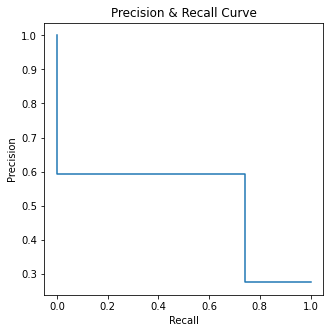

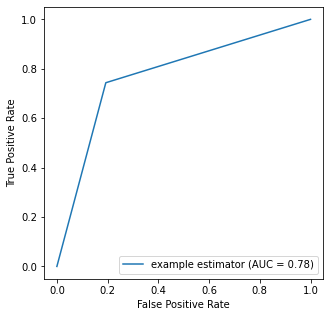

In [17]:
#Lets see precision / recall & ROC curves. First one should better measure for imbalanced set as we have it. 
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay,roc_curve,auc,RocCurveDisplay

plt.rcParams["figure.figsize"] = (5,5) 

precision, recall, _ = precision_recall_curve(y_val, pred_val)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot() 
plt.title('Precision & Recall Curve')
plt.show()

#AUC ROC curve
fpr, tpr, thresholds = roc_curve(y_val, pred_val)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()


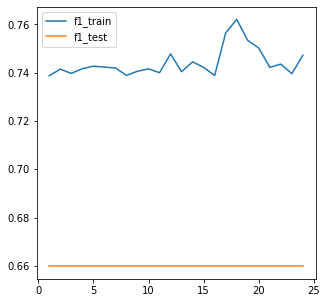

In [18]:
#Reduce number of features by calculating how much of y variance is explained by X variance and setting a treshold
from sklearn.feature_selection import VarianceThreshold
 
def selectionVarianceThreshold(df, variance_threshold=0.0):
    sel = VarianceThreshold(threshold=variance_threshold)
    sel_var=sel.fit_transform(df)
    sel_loc_index = sel.get_support(indices=True)
 
    if len(sel_loc_index)==0:
        return None
    else: 
        return list(df.columns[sel_loc_index])


#Loop that will calculate f1 result depending on variabality explain treshold of X. 
# Essentially it takes columns that have variability bigger than given (note they are divided by 100) and trains model & evaluates it
f1_train=[]
f1_test=[]

for  i in range(1,25,1):
    feats_to_include_VT = selectionVarianceThreshold(X_train, 
                        variance_threshold=i/100)
    rf.fit(X_train[feats_to_include_VT],y_train)
    pred_train=rf.predict(X_train[feats_to_include_VT])
    pred_test=rf.predict(X_test[feats_to_include_VT])
    f1_train.append(f1_score(y_train,pred_train))
    f1_test.append(f1_score(y_val,pred_val))

#draw results of above plot
plt.plot(range(1,25,1),f1_train,label='f1_train')
plt.plot(range(1,25,1),f1_test,label='f1_test')
plt.legend()
plt.show()


In [19]:
#Lets explore how hyperparameters values impact train & test results
param_ = [2,4,6,8,10,11,13,15,17,20,30]

train_scores, test_scores = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = param_, cv = 3,n_jobs=-1,scoring='f1_weighted')

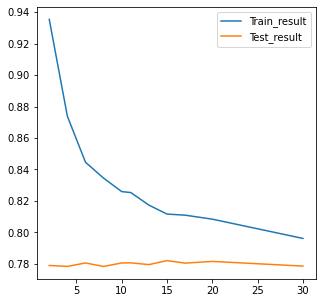

In [20]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.plot(param_,train_scores_mean,label='Train_result')
plt.plot(param_,test_scores_mean,label='Test_result')
plt.legend()
plt.show()

# plt.title("Validation Curve with SVM")
# plt.xlabel(r"$\gamma$")
# plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
# lw = 2
# plt.semilogx(
#     param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
# )
# plt.fill_between(
#     param_range,
#     train_scores_mean - train_scores_std,
#     train_scores_mean + train_scores_std,
#     alpha=0.2,
#     color="darkorange",
#     lw=lw,
# )
# plt.semilogx(
#     param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
# )
# plt.fill_between(
#     param_range,
#     test_scores_mean - test_scores_std,
#     test_scores_mean + test_scores_std,
#     alpha=0.2,
#     color="navy",
#     lw=lw,
# )
# plt.legend(loc="best")
# plt.show()